In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import observations.dimensions.one.sampling as observe
import matplotlib.pyplot as plt

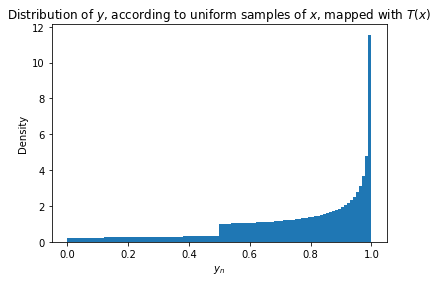

In [3]:
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True)
plt.title("Distribution of $y$, according to uniform samples of $x$, mapped with $T(x)$")
plt.xlabel("$y_n$")
plt.ylabel("Density")
plt.show()

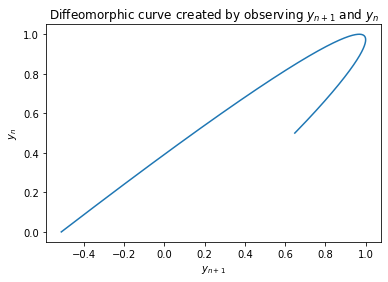

In [4]:
ys = observe.sample(1)

#plt.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], s = 0.5)
plt.plot(numpy.transpose(ys)[1], numpy.transpose(ys)[0])
plt.title("Diffeomorphic curve created by observing $y_{n+1}$ and $y_{n}$")
plt.xlabel('$y_{n+1}$')
plt.ylabel('$y_{n}$')
plt.show()

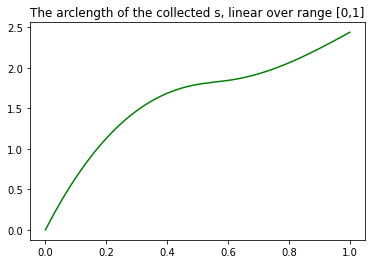

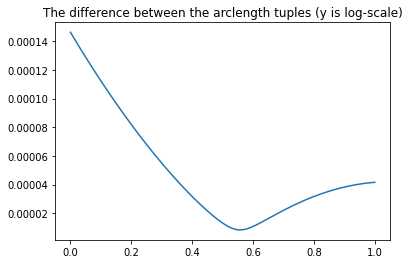

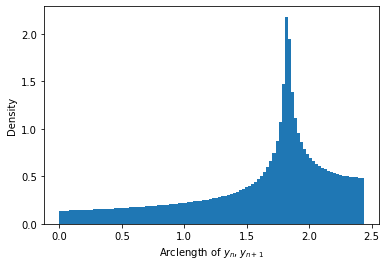

In [5]:
from observations.utils import arclen, lags

alen = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.title("The arclength of the collected s, linear over range [0,1]")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen, label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
plt.show()

training_tuples = list(zip(*lags(arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]]), 1)))
real_difference = [abs(t0 - t1) for t0, t1 in training_tuples]

plt.title("The difference between the arclength tuples (y is log-scale)") # TODO it  is not log scaled as of now
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference)
#plt.yscale("log")
plt.show()

s = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.hist(s, bins=100, density=True)
plt.xlabel("Arclength of $y_{n}, y_{n+1}$")
plt.ylabel("Density")
plt.show()

[Epoch:   1] training loss: 0.004840073  validation loss: 0.000022993
[0.00205202 0.0020524  0.00205278 ... 0.00611504 0.00611538 0.00611619]


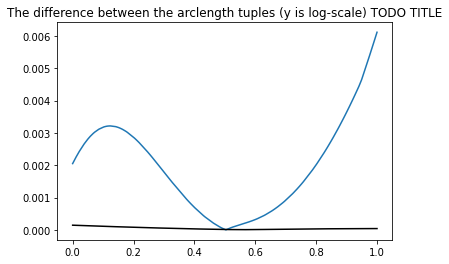

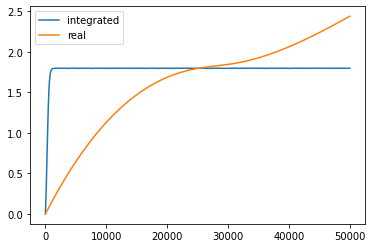

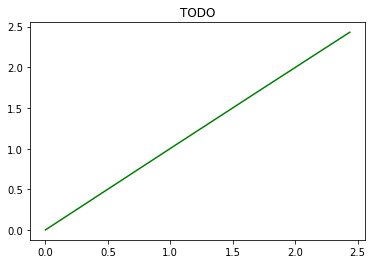

[Epoch:   2] training loss: 0.000002377  validation loss: 0.000006412
[0.00331741 0.00331655 0.00331569 ... 0.00322445 0.00322479 0.00322537]


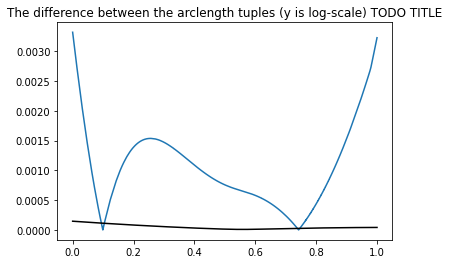

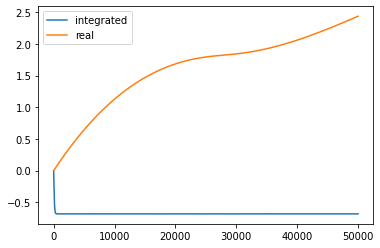

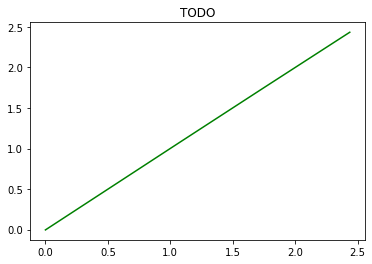

[Epoch:   3] training loss: 0.000001349  validation loss: 0.000003910
[0.00265908 0.00265843 0.00265774 ... 0.00225814 0.00225824 0.00225858]


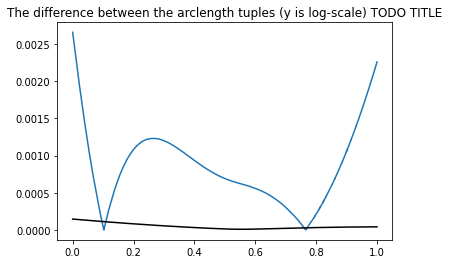

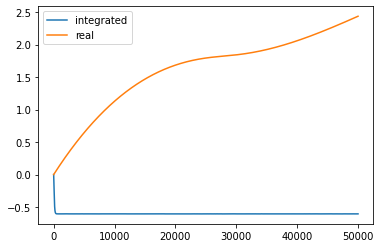

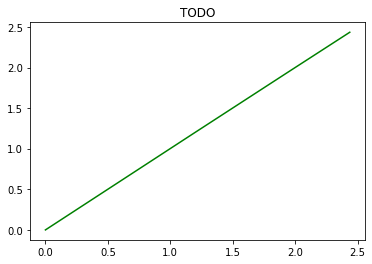

[Epoch:   4] training loss: 0.000000626  validation loss: 0.000001343
[0.00139116 0.00139082 0.00139051 ... 0.0016044  0.0016045  0.00160484]


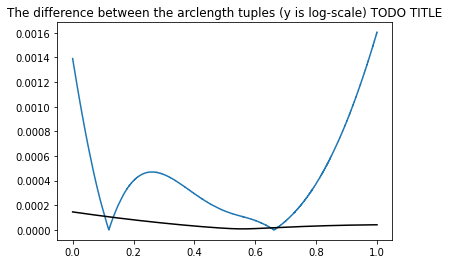

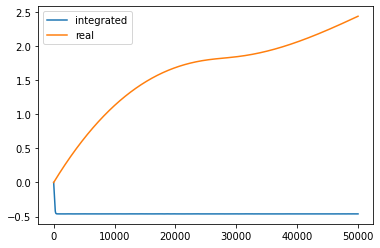

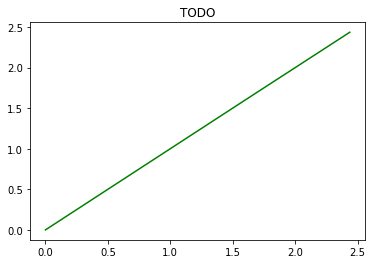

[Epoch:   5] training loss: 0.000000156  validation loss: 0.000000168
[9.35631469e-05 9.35569392e-05 9.35109976e-05 ... 5.94694097e-04
 5.94555884e-04 5.94894842e-04]


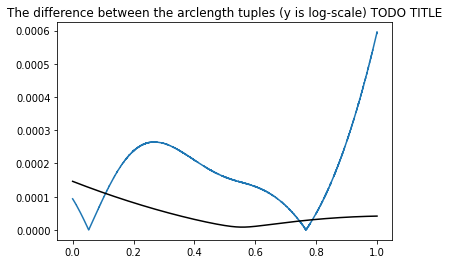

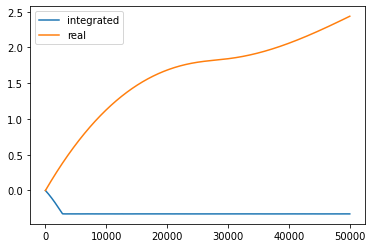

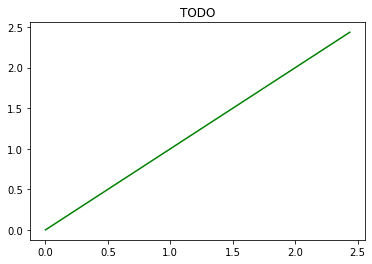

[Epoch:   6] training loss: 0.000000016  validation loss: 0.000000024
[0.00029581 0.00029571 0.00029563 ... 0.000187   0.00018686 0.00018696]


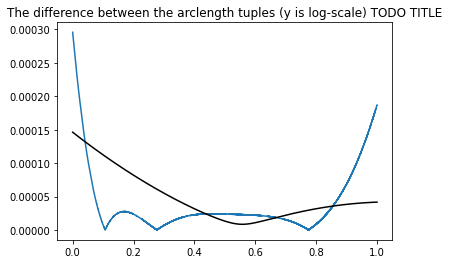

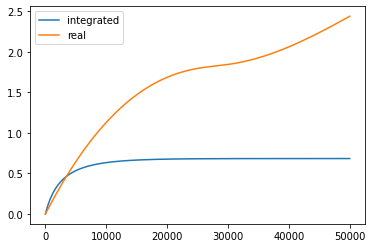

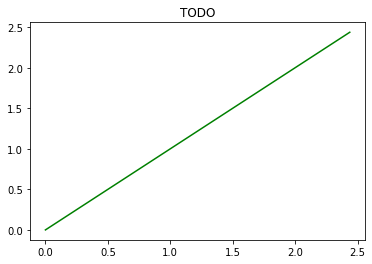

[Epoch:   7] training loss: 0.000000005  validation loss: 0.000000015
[4.04350460e-04 4.04233696e-04 4.04140580e-04 ... 9.61608478e-05
 9.60226355e-05 9.61231747e-05]


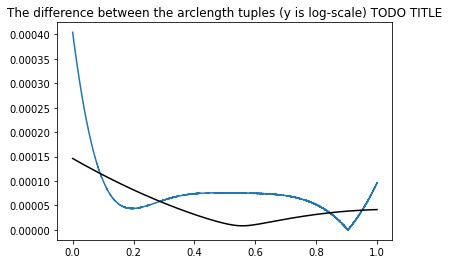

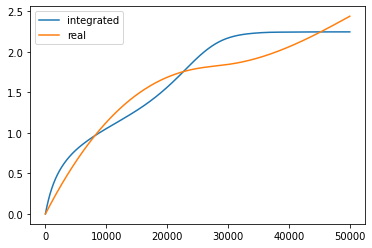

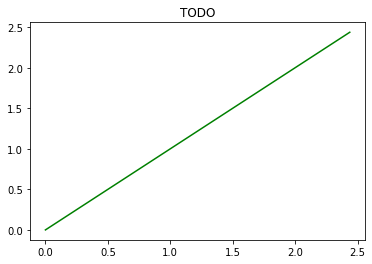

[Epoch:   8] training loss: 0.000000004  validation loss: 0.000000030
[4.12498921e-04 4.12421884e-04 4.12354845e-04 ... 2.22510882e-05
 2.23512945e-05 2.24518338e-05]


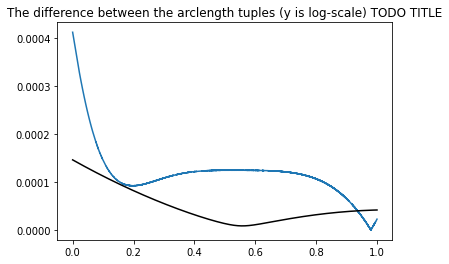

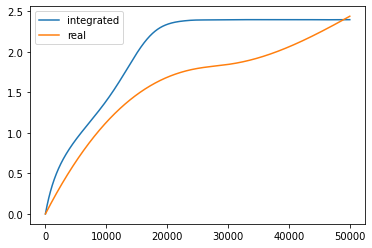

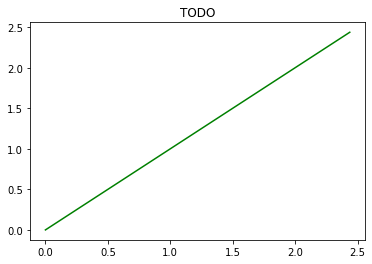

[Epoch:   9] training loss: 0.000000004  validation loss: 0.000000016
[0.00023933 0.00023923 0.00023918 ... 0.00010522 0.00010508 0.00010518]


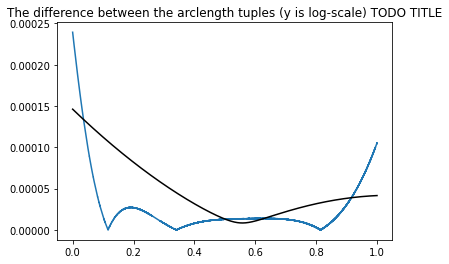

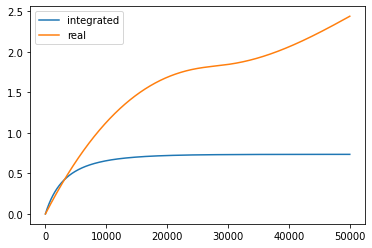

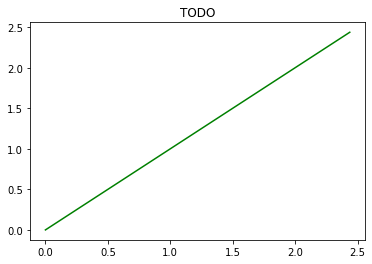

[Epoch:  10] training loss: 0.000000003  validation loss: 0.000000007
[2.90894270e-04 2.90822239e-04 2.90770101e-04 ... 5.10997363e-05
 5.11999426e-05 5.13004819e-05]


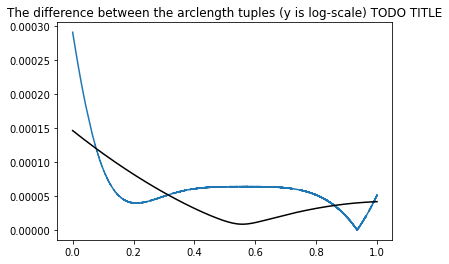

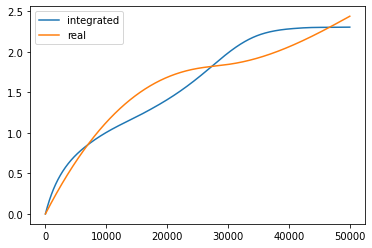

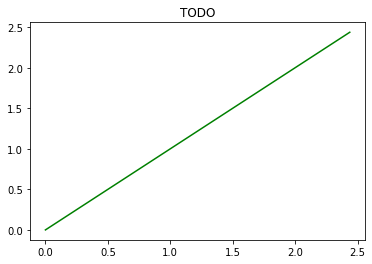

[Epoch:  11] training loss: 0.000000003  validation loss: 0.000000008
[2.72908568e-04 2.72853913e-04 2.72812921e-04 ... 8.30478259e-05
 8.29096136e-05 8.30101529e-05]


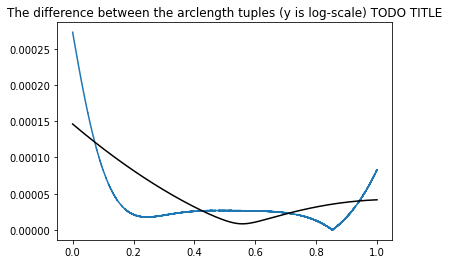

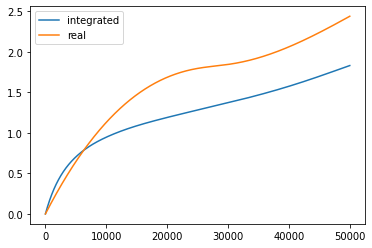

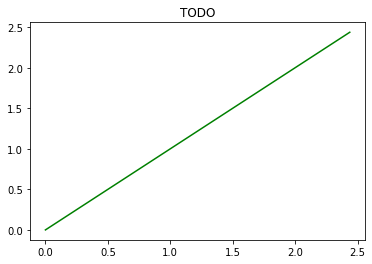

[Epoch:  12] training loss: 0.000000002  validation loss: 0.000000008
[2.69930810e-04 2.69874932e-04 2.69819068e-04 ... 8.66122922e-06
 8.52301695e-06 8.62355619e-06]


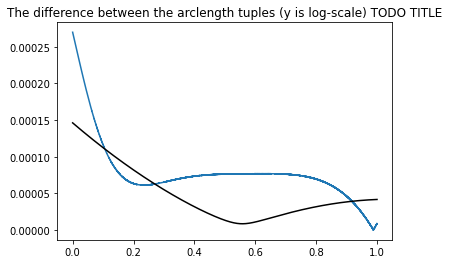

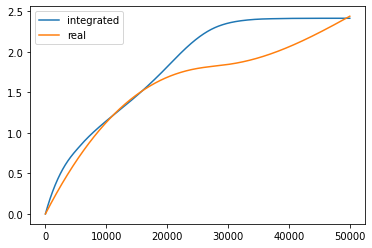

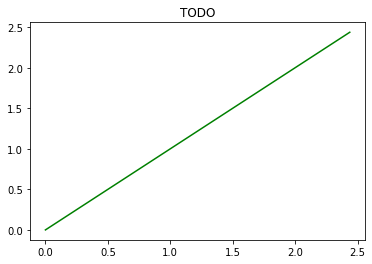

[Epoch:  13] training loss: 0.000000002  validation loss: 0.000000004
[2.31701881e-04 2.31693209e-04 2.31664645e-04 ... 3.94172259e-05
 3.92790136e-05 3.93795529e-05]


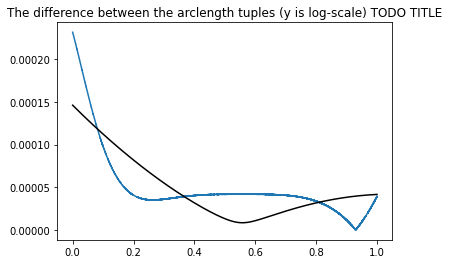

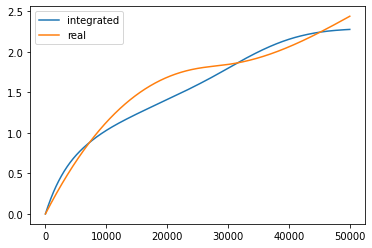

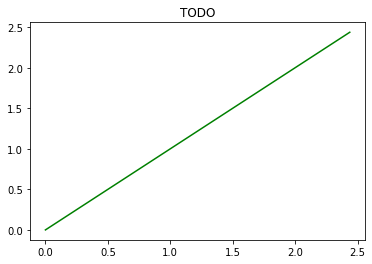

[Epoch:  14] training loss: 0.000000002  validation loss: 0.000000014
[2.43458897e-04 2.43463846e-04 2.43439007e-04 ... 3.37772779e-05
 3.39154901e-05 3.35765323e-05]


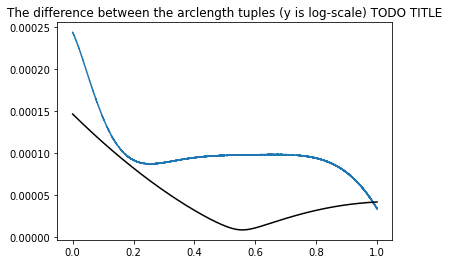

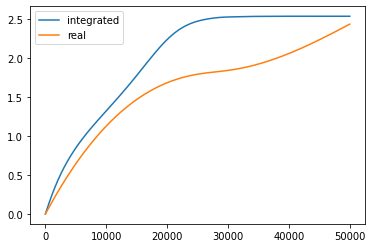

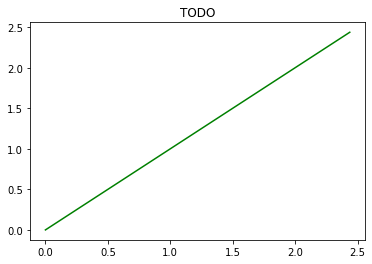

[Epoch:  15] training loss: 0.000000001  validation loss: 0.000000003
[2.04020485e-04 2.03999401e-04 2.04000639e-04 ... 1.08069964e-05
 1.04303656e-05 1.07693234e-05]


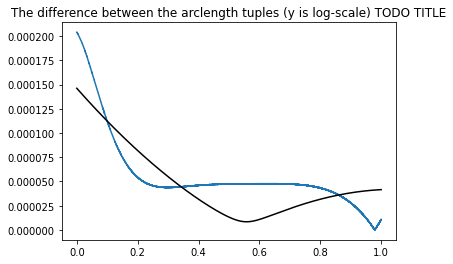

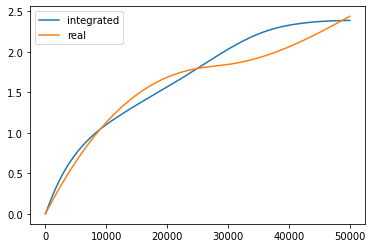

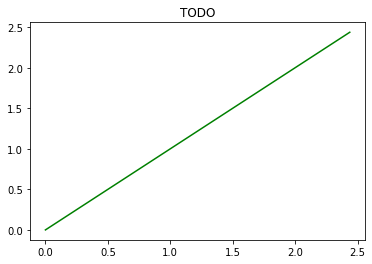

[Epoch:  16] training loss: 0.000000001  validation loss: 0.000000004
[1.42782927e-04 1.42760576e-04 1.42776715e-04 ... 3.01189013e-05
 2.99806891e-05 3.00812283e-05]


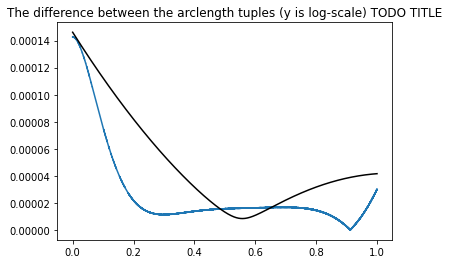

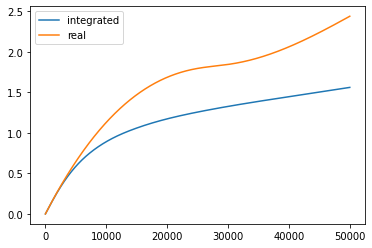

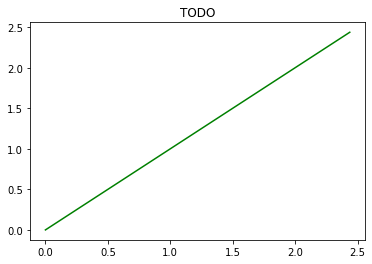

[Epoch:  17] training loss: 0.000000001  validation loss: 0.000000006
[1.27729028e-04 1.27756329e-04 1.27753842e-04 ... 3.67946216e-05
 3.66564093e-05 3.67569485e-05]


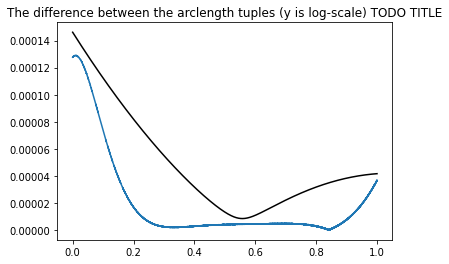

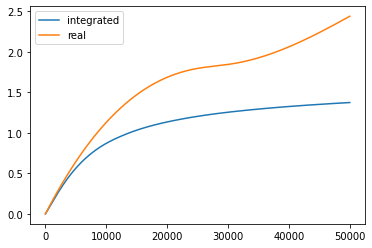

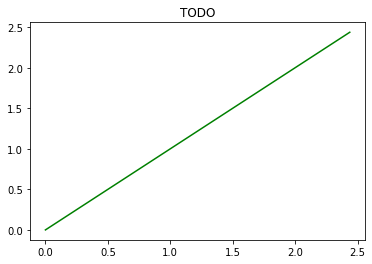

[Epoch:  18] training loss: 0.000000001  validation loss: 0.000000006
[1.23428807e-04 1.23396517e-04 1.23428780e-04 ... 3.51256915e-05
 3.49874792e-05 3.50880185e-05]


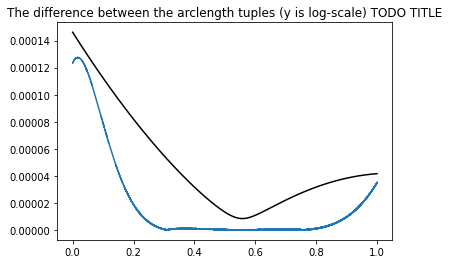

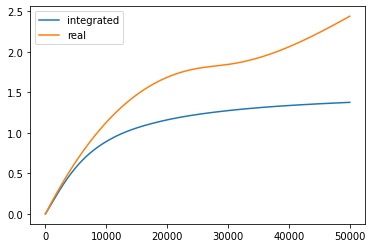

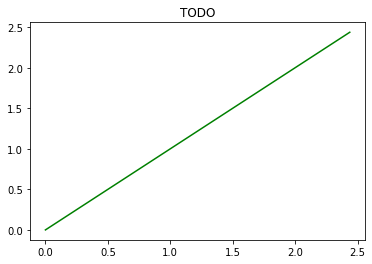

In [ ]:
import dynamics.nets as nets
import dynamics.utils
import torch
import torch.nn as nn

model = nets.RK4N(input_size = 1, num_param=1, hidden_size=20, h=1, num_hidden_layers=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
train_loader, val_loader = dynamics.utils.training_validator_splitter(training_tuples, bs=10)

# Losses
train_losses = []
val_losses = []

for epoch in range(1, 50):  # loop over the dataset multiple times
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = torch.unsqueeze(inputs, 1).float()
        labels = torch.unsqueeze(labels, 1).float()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # For statistics
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = torch.unsqueeze(inputs, 1).float()
            labels = torch.unsqueeze(labels, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %3d] training loss: %.9f  validation loss: %.9f' %
            (epoch, train_loss,val_loss))


###############################

    def s_n1(s_n):
        return model(torch.tensor([[s_n]]).float()).item()

    def s_n1_tensor(s_n):
        return model(s_n.float())

    fitted_values_normalized = s_n1_tensor(torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1))
    #print(normalizer.inverse_transform(fitted_values.detach().numpy()))
    training_tuples_fitted_normalized = torch.cat((torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1), fitted_values_normalized), 1).detach().numpy()
    training_tuples_fitted = training_tuples_fitted_normalized#normalizer.inverse_transform(training_tuples_fitted_normalized)
    #training_tuples_fitted = [(sn, s_n1(sn)) for (sn, _) in training_tuples]

    difference = numpy.abs(training_tuples_fitted[:, 0] - training_tuples_fitted[:, 1])
    print(difference)

    plt.title("The difference between the arclength tuples (y is log-scale) TODO TITLE")
    plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], difference)
    plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference, color='black')
    #plt.yscale("log")
    plt.show()

    #print(training_tuples)
    #print(s_n1(1.716607903670211))

    from scipy.integrate import solve_ivp

    def f(t, y):
        return model.one_step(torch.FloatTensor([y])).detach().numpy()[0]
    t_eval = numpy.linspace(0, observe.samplesize, observe.samplesize)
    sol = solve_ivp(f, [0, observe.samplesize], [0], t_eval=t_eval)

    plt.plot(t_eval, sol.y[0], label="integrated neural network")
    plt.plot(t_eval[1:], alen, label="real arclength")
    plt.legend()
    plt.show()

    plt.title("TODO") # TODO: write title
    plt.plot(numpy.linspace(0, s[-1], 1000), [s_n1(x) for x in numpy.linspace(0, s[-1], 1000)], label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
    plt.show()
###############################


plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.yscale("log")
plt.legend()
plt.show()